# Créer des handwritten digits avec des GAN 


[GAN ou Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) 

<img src="https://www.tensorflow.org/tutorials/generative/images/gan1.png" width=400>


During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

In [121]:
!pip install tensorflow-gpu==2.0.0beta1
!pip install pprint 
!pip install simple_chalk
from simple_chalk import chalk, green, red, blue
import tensorflow as tf, numpy as np , matplotlib.pyplot as plt, os, pandas as pd
from pprint import pprint
from IPython import display
import time
import os 
import glob

* get data [`tf.keras.datasets.mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [123]:
mnist_data = tf.keras.datasets.mnist.load_data()
x_train, y_train = mnist_data[0]
print(red(x_train.shape), red('is the shape for train img'))
print(red(y_train.shape), red('is the shape for train labels'))

x_test, y_test = mnist_data[1]
print(green(x_test.shape), green('is the shape for test img'))
print(green(y_test.shape), green('is the shape for test labels'))

WIDTH = x_train.shape[-1]
HEIGHT = x_train.shape[-2]
TEST_SAMPLES = y_test.shape[0]
TRAIN_SAMPLES = y_test.shape[0]

(60000, 28, 28) is the shape for train img
(60000,) is the shape for train labels
(10000, 28, 28) is the shape for test img
(10000,) is the shape for test labels


<h3> pre processing </h3>

  * reshape images into following form (sample, height, width, channels = 1). 
  * make images `float32`
  * we want pixels between intervals [-1, 1]. Vous pourrez tout simplement soustraire chacun des pixels par 127.5 (255/2) puis diviser le tout par 127.5 (255/2)

If you reshape it with a -1 in the first dimension what you are doing is saying that you will feed in a 4D batch of images (shaped [batch_size, height, width, color_channels], and you are allowing the batch size to be dynamic (which is common to do).

In [124]:
X_train = tf.reshape(x_train, [-1, HEIGHT, WIDTH, 1])
X_train = tf.cast(X_train, dtype=tf.float32)
print(X_train[0][10].numpy(), red('pixel values line 10'))
X_train = X_train / 255
print(X_train[0][10].numpy(), green('normalized pixel values line 10'))
X_train.shape

[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 14.]
 [  1.]
 [154.]
 [253.]
 [ 90.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]] pixel values line 10
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05490196]
 [0.00392157]
 [0.6039216 ]
 [0.99215686]
 [0.3529412 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]] normalized pixel values line 10


TensorShape([60000, 28, 28, 1])

Random image display

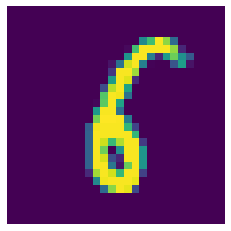

In [125]:
random_index = np.random.randint(TRAIN_SAMPLES)
random_images = X_train[random_index]
squeezed_img = tf.squeeze(random_images)
plt.axis('off')
plt.imshow(squeezed_img)

[`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

we will use dataset_x_train in the the end to train our generator 

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 6000
dataset_x_train  = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_y_train = tf.data.Dataset.from_tensor_slices(y_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = tf.data.Dataset.zip((dataset_x_train, dataset_y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [127]:
X_test = tf.reshape(x_test, [-1, HEIGHT, WIDTH, 1])
X_test = tf.cast(X_test, dtype=tf.float32)
print(X_test[0][10].numpy(), red('pixel values line 10'))
X_test = (X_test - 127.5) / 127.5 # we use tang activation func in end so needs to be within -1/1
print(X_test[0][10].numpy(), green('normalized pixel values line 10'))
X_test.shape

[[  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ 17.]
 [ 66.]
 [ 14.]
 [ 67.]
 [ 67.]
 [ 67.]
 [ 59.]
 [ 21.]
 [236.]
 [254.]
 [106.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]] pixel values line 10
[[-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-0.8666667 ]
 [-0.48235294]
 [-0.8901961 ]
 [-0.4745098 ]
 [-0.4745098 ]
 [-0.4745098 ]
 [-0.5372549 ]
 [-0.8352941 ]
 [ 0.8509804 ]
 [ 0.99215686]
 [-0.16862746]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]] normalized pixel values line 10


TensorShape([10000, 28, 28, 1])

In [128]:
features, labels = next(iter(dataset_train.take(1)))
print(features.shape)
print(labels.shape)

(256, 28, 28, 1)
(256,)


How it works

<img src="https://miro.medium.com/max/1814/1*Sqhji7Zz4IK2HDgCOabhXQ.png" width=500>

# _generator_. 

1.  takes noise as input than we increasingly our generated images become better. this is our seed 

2.  A first dense layer will take this input

3.  upscaling until we get the image of size (28,28,1)

🚨🚨 Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh. 🚨🚨 


In [0]:
NOISE_N = 100
IMAGE_DIM = 28

noise = tf.random.normal([1,100])

# in between we have trainable Weights and Bias

def make_generator_model():
    model = tf.keras.Sequential()
    # 7w by 7h 256filters 
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_N,)))
    # avoid overfitting 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    # conv is matrix if you multiply this by an img you get output conv 
    # here we want to do the reverse 
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 2x2 stride because we do inverse of conv
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # our last upscaling we want to be sure it is the dimensions of the image
    assert model.output_shape == (None, IMAGE_DIM, IMAGE_DIM, 1)

    return model


[LeakyRelu()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LeakyReLU) 

It allows a small gradient 

*  when the unit is not active: f(x) = alpha * x for x < 0 --> leaves a gradient instead of putting the neuron at 0 when not active (what relu does)
*  f(x) = x for x >= 0.


 [_Conv2DTranspose_](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose)

The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.


* random noise image: 
  * tensor with random pixels ---> [`tf.random.normal`](https://www.tensorflow.org/api_docs/python/tf/random/normal)
  * apply the noise to the generator 
  * Visualisez avec plt

(1, 28, 28, 1)


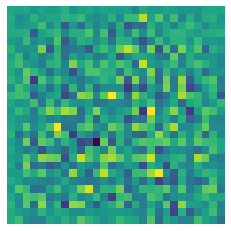

In [130]:
generator = make_generator_model()
rndm_img = generator(noise)
print(rndm_img.shape)
plt.axis('off')
plt.imshow(tf.squeeze(rndm_img))

# __Discriminator__

= will try to predict if our generated image is a true one or not so can be a binary classifier 

*  Dense layer: A linear operation in which every input is connected to every output by a weight (so there are n_inputs * n_outputs weights - which can be a lot!). Generally followed by a non-linear activation function
*  Convolutional layer: A linear operation using a subset of the weights of a dense layer. Nearby inputs are connected to nearby outputs (specifically - a convolution 713 ). The weights for the convolutions at each location are shared. Due to the weight sharing, and the use of a subset of the weights of a dense layer, there’s far less weights than in a dense layer. Generally followed by a non-linear activation function
*  Pooling layer: Replace each patch in the input with a single output, which is the maximum (can also be average) of the input patch
*  Normalisation layer: Scale the input so that the output has near to a zero mean and unit standard deviation, to allow for faster and more resilient training

In [0]:
# output this time is 0/1 --> 0 false 1 true 
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_DIM, IMAGE_DIM, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    # adds some non linearity 
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    # to go from conv to dense
    model.add(tf.keras.layers.Dense(1))

    return model

* test predictions of our discriminator

In [149]:
discriminator = make_discriminator_model()
decision = discriminator(rndm_img)
print(green(decision))

[[-0.00140939]]


In [150]:
decision2 = discriminator(np.random.rand(1,28,28,1).astype("float32"))
print(decision2)
print(red('closer to 0 means it classifies it as fake'))

tf.Tensor([[0.01260547]], shape=(1, 1), dtype=float32)
closer to 0 means it classifies it as fake


# Loss functions 


  * **discriminator_loss** 
  * **generator_loss** 
  
<img src="https://i.stack.imgur.com/rNI4P.png" width=500>

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [152]:
# real_img_pred = discriminator(real_images)
# fake_img_pred = discriminator(real_images)
print(red('the predictions look like this'),  decision)
print(green('the ones like looks like this'),  tf.ones_like(decision))
print(blue('the zero like looks like this'),  tf.zeros_like(decision))
print(red('example of cross entropy real'),  cross_entropy(tf.ones_like(decision), decision))
print(green('example of cross entropy fake'),  cross_entropy(tf.zeros_like(decision), decision))

def discriminator_loss(real_img_predictions, fake_img_predictions):
  real_loss = cross_entropy(tf.ones_like(real_img_predictions), real_img_predictions) 
  # we use ones because the values should be 1 
  # the real entropy / loss will be bigger if real_img_predictions is close to 0 which means 
  # the discrim thinks it is fake
  fake_loss = cross_entropy(tf.zeros_like(fake_img_predictions), fake_img_predictions)
  # we use zeros because the values should be 0 -- because these are fakes
  # the fake entropy / loss will be bigger if fake_img_predictions is close to 1 which means 
  # the discrim thinks it is real 
  total_loss = real_loss + fake_loss
  return total_loss
  # in total we want total loss to be low because 
  # this means it does well in telling that fake is fake and real is real 

the predictions look like this tf.Tensor([[-0.00140939]], shape=(1, 1), dtype=float32)
the ones like looks like this tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
the zero like looks like this tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
example of cross entropy real tf.Tensor(0.6938521, shape=(), dtype=float32)
example of cross entropy fake tf.Tensor(0.6924427, shape=(), dtype=float32)


* `generator_loss` which finds at which moment do we dupe `discriminator`. 

*  `generator_loss` will go down if `discriminator` defines fake img as a real one

*  if the prediction is closer to 1 this means our generator is doing better / for this our generator should be rewarded 

*  which also means our cross_entropy / loss will diminish

In [0]:
def generator_loss(fake_img_predictions):
  return cross_entropy(tf.ones_like(fake_img_predictions), fake_img_predictions)

* Définissons maintenant deux optimiseurs pour nos deux fonctions de coût. Créez deux optimiseurs Adam avec un learning rate à `1e-4` chacun 

In [0]:
lr = 0.001

optimizer_generator = tf.keras.optimizers.Adam(learning_rate=lr)
optimizer_discriminator = tf.keras.optimizers.Adam(learning_rate=lr)

# training training training

---

start by defining some variables:



*  EPOCHS / NOISE_N 

*  num_examples_to_generate = 16 (random images to make)

*  seed = tf.random.normal([num_examples_to_generate, noise_dim]) ----> our random images seed array  

In [0]:
EPOCHS = 50
num_examples_to_generate = 16
SEED = tf.random.normal([num_examples_to_generate, NOISE_N])

In [0]:
def calc_apply_gradients(fake_img_predictions ,
              real_img_predictions, 
              generator_model=generator, 
              discriminator_model=discriminator, 
              generator_optimizer=optimizer_generator, 
              discriminator_optimizer=optimizer_discriminator):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # our loss function is cross entropy
    gen_loss = generator_loss(fake_img_predictions) # will be rewarded if discriminator makes mistakes
    disc_loss = discriminator_loss(real_img_predictions, fake_img_predictions)
    
    
  gen_gradients = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

  # we need to apply the found gradients to the variables of the model 
  generator_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator_model.trainable_variables))
  return

------

<h1>Train step</h1>


In [0]:
def step_train(imagebatch):
  noise=tf.random.normal([BATCH_SIZE, NOISE_N])
  
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_img = generator(noise)
    real_img_predictions = discriminator(imagebatch)
    fake_img_predictions = discriminator(generated_img)
    # our loss function is cross entropy
    gen_loss = generator_loss(fake_img_predictions) # will be rewarded if discriminator makes mistakes
    disc_loss = discriminator_loss(real_img_predictions, fake_img_predictions)
    
    
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # we need to apply the found gradients to the variables of the model 
  optimizer_generator.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  optimizer_discriminator.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))


In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      step_train(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             SEED)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           SEED)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

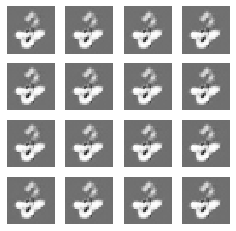

NameError: ignored

In [172]:
train(dataset_x_train, EPOCHS)